## DUSP1 smiFISH Classification Workflow

This notebook processes experimental data from BigFish and CellProperties CSV files to classify DUSP1 smiFISH spots. Below is an outline of the workflow:

### Input:
- BigFish CSV files
- CellProperties CSV files

### Workflow Steps:
1. **Merge Experimental Data**  
    Combine data from the input CSV files for unified analysis.

2. **Signal-to-Noise Ratio (SNR) Analysis**  
    Perform SNR analysis to classify and filter spots based on signal quality.

3. **Measurement Analysis**  
    Conduct measurement analysis to extract relevant features from the data.

4. **Data Merging**  
    Merge all processed data into a single dataset for further analysis.

5. **Create Training Spot Crops (11px x 11px)**  
    Generate training data for machine learning models:
    - Select 1000 spots from each `h5_idx`, ensuring variation across cells and fields of view (FOVs).
    - Use the DUSP1 Display Manager to safely load spot channel images.
    - Perform max projection of images along the z-axis to create 2D (x, y) representations.
    - Extract 11px x 11px crops centered on each spot.
    - Rescale intensity for visualization purposes.
    - Display 100 sample spot crops for quality inspection before saving all crops to a directory.

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dask.array as da
import os
import sys
import logging
import seaborn as sns
import datetime

# Today's date
today = datetime.date.today()
# Format date as 'Mar21' (for example)
date_str = today.strftime("%b%d")

logging.getLogger('matplotlib.font_manager').disabled = True
numba_logger = logging.getLogger('numba')
numba_logger.setLevel(logging.WARNING)

matplotlib_logger = logging.getLogger('matplotlib')
matplotlib_logger.setLevel(logging.WARNING)

src_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
print(src_path)
sys.path.append(src_path)

from src.Analysis_DUSP1_v2 import DUSP1AnalysisManager, SNRAnalysis, DUSP1Measurement, DUSP1DisplayManager, SpotCropSampler, DUSP1_filtering

In [ ]:
loc = None
log_location = r'/Volumes/share/Users/Eric/GR_DUSP1_reruns'
save_dir = r'/Volumes/share/Users/Eric/DUSP1_SpotCropsV2'
df_outut = r'/Volumes/share/Users/Eric/DUSP1_SpotCropsV2/SNR_dataframes'
if not os.path.exists(df_outut):
    os.makedirs(df_outut)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Define Thresholds
abs_threshold = 4
mg_threshold = 3

# crop size
pad = 2

    # DUSP1 Replica D 3hr 100nM time-sweep R1

In [ ]:
am = DUSP1AnalysisManager(location=loc, log_location=log_location, mac=True) 
am.select_analysis('DUSP1_D_Final')

spots_df = am.select_datasets("spotresults", dtype="dataframe")
clusters_df = am.select_datasets("clusterresults", dtype="dataframe")
props_df = am.select_datasets("cell_properties", dtype="dataframe")

snr_df = SNRAnalysis(spots_df, props_df, clusters_df, abs_threshold=abs_threshold, mg_threshold=mg_threshold)

merged_spots_df, merged_clusters_df, merged_cellprops_df = snr_df.get_results()

# Create an instance of the DUSP1Measurement class.
dusp = DUSP1Measurement(merged_spots_df, merged_clusters_df, merged_cellprops_df)

# Process the data with a chosen threshold method
cell_level_results = dusp.measure(abs_threshold=abs_threshold, mg_threshold=mg_threshold)

# Add replica level unique IDs for 'unique_cell_id', 'unique_spot_id', and 'unique_cluster_id'
# Get number of digits in the max unique_cell_id
max_id = merged_cellprops_df['unique_cell_id'].max()
num_digits = len(str(max_id))

# Calculate multiplier to add a '1' followed by the right number of zeroes - prefix is specific for each experiment (e.g., repD:1, repE:2, etc.)
rep_prefix = 10
prefix = rep_prefix ** num_digits  # e.g., if max_id = 30245 → prefix = 100000

# Apply prefix to all related DataFrames
merged_spots_df['unique_cell_id'] += prefix
merged_clusters_df['unique_cell_id'] += prefix
merged_cellprops_df['unique_cell_id'] += prefix
cell_level_results['unique_cell_id'] += prefix

# Repeat for unique_spot_id and unique_cluster_id
max_spot_id = merged_spots_df['unique_spot_id'].max()
spot_prefix = rep_prefix ** len(str(max_spot_id))
merged_spots_df['unique_spot_id'] += spot_prefix

max_cluster_id = merged_clusters_df['unique_cluster_id'].max()
cluster_prefix = rep_prefix ** len(str(max_cluster_id))
merged_clusters_df['unique_cluster_id'] += cluster_prefix

# Save all results to CSV
rep_string = 'DUSP1_D_Final'
output_dir = df_outut
os.makedirs(output_dir, exist_ok=True)
cell_level_results.to_csv(os.path.join(output_dir, f"{rep_string}_cell_level_results_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)
merged_spots_df.to_csv(os.path.join(output_dir, f"{rep_string}_merged_spots_df_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)
merged_clusters_df.to_csv(os.path.join(output_dir, f"{rep_string}_merged_clusters_df_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)
merged_cellprops_df.to_csv(os.path.join(output_dir, f"{rep_string}_merged_cellprops_df_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)

# instantiate sampler
sampler = SpotCropSampler(
    spots_df=merged_spots_df,
    clusters_df=merged_clusters_df,
    cellprops_df=merged_cellprops_df,
    mount_prefix="/Volumes/share"
)

# # — TEST RUN: only 3 displays, no files written —
# crops, meta = sampler.run(
#     save_dir=save_dir,
#     display=1,
#     save_individual=False,
#     save_summary=False,
#     pad=2,
#     cells_per_quad=1,
#     spots_per_cell=20,
#     spotChannel=0
# )

# choose a prefix for this experiment
prefix = "DUSP1_D_Final_MG3_Abs4"

# full run, no per-spot files, but summary files with prefix
crops, meta = sampler.run(
    save_dir=save_dir,
    display=0,
    save_individual=False,
    save_summary=True,
    file_prefix=prefix,
    pad=pad,
    cells_per_quad=1,
    spots_per_cell=20,
    spotChannel=0
)

In [ ]:
# # Directory where you saved the summary files
# save_dir = "/Volumes/share/Users/Eric/DUSP1_SpotCrops"

# # 1) Load the data
# crops = np.load(os.path.join(save_dir, f"{prefix}_all_crops.npy"))  # shape: (N, 7, 7)
# meta  = pd.read_csv(os.path.join(save_dir, f"{prefix}_all_crop_metadata.csv"))

# # 2) Choose a few random examples (up to 5)
# num_examples = min(5, len(crops))
# indices = np.random.choice(len(crops), size=num_examples, replace=False)

# # 3) Display them
# fig, axes = plt.subplots(1, num_examples, figsize=(num_examples * 3, 3))
# for ax, idx in zip(axes, indices):
#     patch = crops[idx]
#     info  = meta.iloc[idx]
    
#     ax.imshow(patch, cmap='gray')
#     ax.set_title(
#         f"Cell {info.unique_cell_id}\n"
#         f"Spot {info.unique_spot_id}\n"
#         f"MG_SNR={info.MG_SNR:.1f}, SNR={info.snr:.1f}\n"
#         f"MG_pass={info.MG_pass}"
#     )
#     ax.axis('off')

# plt.tight_layout()
# plt.show()

    # DUSP1 Replica E 3hr 100nM time-sweep R2

In [ ]:
am = DUSP1AnalysisManager(location=loc, log_location=log_location, mac=True) 
am.select_analysis('DUSP1_E_Final')

spots_df = am.select_datasets("spotresults", dtype="dataframe")
clusters_df = am.select_datasets("clusterresults", dtype="dataframe")
props_df = am.select_datasets("cell_properties", dtype="dataframe")

snr_df = SNRAnalysis(spots_df, props_df, clusters_df, abs_threshold=abs_threshold, mg_threshold=mg_threshold)

merged_spots_df, merged_clusters_df, merged_cellprops_df = snr_df.get_results()

# Create an instance of the DUSP1Measurement class.
dusp = DUSP1Measurement(merged_spots_df, merged_clusters_df, merged_cellprops_df)

# Process the data with a chosen threshold method
cell_level_results = dusp.measure(abs_threshold=abs_threshold, mg_threshold=mg_threshold)

# Add replica level unique IDs for 'unique_cell_id', 'unique_spot_id', and 'unique_cluster_id'
# Get number of digits in the max unique_cell_id
max_id = merged_cellprops_df['unique_cell_id'].max()
num_digits = len(str(max_id))

# Calculate multiplier to add a '1' followed by the right number of zeroes - prefix is specific for each experiment (e.g., repD:1, repE:2, etc.)
rep_prefix = 20
prefix = rep_prefix ** num_digits  # e.g., if max_id = 30245 → prefix = 100000

# Apply prefix to all related DataFrames
merged_spots_df['unique_cell_id'] += prefix
merged_clusters_df['unique_cell_id'] += prefix
merged_cellprops_df['unique_cell_id'] += prefix
cell_level_results['unique_cell_id'] += prefix

# Repeat for unique_spot_id and unique_cluster_id
max_spot_id = merged_spots_df['unique_spot_id'].max()
spot_prefix = rep_prefix ** len(str(max_spot_id))
merged_spots_df['unique_spot_id'] += spot_prefix

max_cluster_id = merged_clusters_df['unique_cluster_id'].max()
cluster_prefix = rep_prefix ** len(str(max_cluster_id))
merged_clusters_df['unique_cluster_id'] += cluster_prefix

# Save all results to CSV
rep_string = 'DUSP1_E_Final'
output_dir = df_outut
os.makedirs(output_dir, exist_ok=True)
cell_level_results.to_csv(os.path.join(output_dir, f"{rep_string}_cell_level_results_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)
merged_spots_df.to_csv(os.path.join(output_dir, f"{rep_string}_merged_spots_df_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)
merged_clusters_df.to_csv(os.path.join(output_dir, f"{rep_string}_merged_clusters_df_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)
merged_cellprops_df.to_csv(os.path.join(output_dir, f"{rep_string}_merged_cellprops_df_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)

# instantiate sampler
sampler = SpotCropSampler(
    spots_df=merged_spots_df,
    clusters_df=merged_clusters_df,
    cellprops_df=merged_cellprops_df,
    mount_prefix="/Volumes/share"
)

# # — TEST RUN: only 3 displays, no files written —
# crops, meta = sampler.run(
#     save_dir=save_dir,
#     display=3,
#     save_individual=False,
#     save_summary=False,
#     pad=pad,
#     cells_per_quad=1,
#     spots_per_cell=20,
#     spotChannel=0
# )

# choose a prefix for this experiment
prefix = "DUSP1_E_Final_MG3_Abs4"

# full run, no per-spot files, but summary files with prefix
crops, meta = sampler.run(
    save_dir=save_dir,
    display=0,
    save_individual=False,
    save_summary=True,
    file_prefix=prefix,
    pad=pad,
    cells_per_quad=1,
    spots_per_cell=20,
    spotChannel=0
)

    # DUSP1 Replica F 3hr 100nM time-sweep R3

In [ ]:
am = DUSP1AnalysisManager(location=loc, log_location=log_location, mac=True) 
am.select_analysis('DUSP1_F_Final')

spots_df = am.select_datasets("spotresults", dtype="dataframe")
clusters_df = am.select_datasets("clusterresults", dtype="dataframe")
props_df = am.select_datasets("cell_properties", dtype="dataframe")

snr_df = SNRAnalysis(spots_df, props_df, clusters_df, abs_threshold=abs_threshold, mg_threshold=mg_threshold)

merged_spots_df, merged_clusters_df, merged_cellprops_df = snr_df.get_results()

# Create an instance of the DUSP1Measurement class.
dusp = DUSP1Measurement(merged_spots_df, merged_clusters_df, merged_cellprops_df)

# Process the data with a chosen threshold method
cell_level_results = dusp.measure(abs_threshold=abs_threshold, mg_threshold=mg_threshold)

# Add replica level unique IDs for 'unique_cell_id', 'unique_spot_id', and 'unique_cluster_id'
# Get number of digits in the max unique_cell_id
max_id = merged_cellprops_df['unique_cell_id'].max()
num_digits = len(str(max_id))

# Calculate multiplier to add a '1' followed by the right number of zeroes - prefix is specific for each experiment (e.g., repD:1, repE:2, etc.)
rep_prefix = 30
prefix = rep_prefix ** num_digits  # e.g., if max_id = 30245 → prefix = 100000

# Apply prefix to all related DataFrames
merged_spots_df['unique_cell_id'] += prefix
merged_clusters_df['unique_cell_id'] += prefix
merged_cellprops_df['unique_cell_id'] += prefix
cell_level_results['unique_cell_id'] += prefix

# Repeat for unique_spot_id and unique_cluster_id
max_spot_id = merged_spots_df['unique_spot_id'].max()
spot_prefix = rep_prefix ** len(str(max_spot_id))
merged_spots_df['unique_spot_id'] += spot_prefix

max_cluster_id = merged_clusters_df['unique_cluster_id'].max()
cluster_prefix = rep_prefix ** len(str(max_cluster_id))
merged_clusters_df['unique_cluster_id'] += cluster_prefix

# Save all results to CSV
rep_string = 'DUSP1_F_Final'
output_dir = df_outut
os.makedirs(output_dir, exist_ok=True)
cell_level_results.to_csv(os.path.join(output_dir, f"{rep_string}_cell_level_results_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)
merged_spots_df.to_csv(os.path.join(output_dir, f"{rep_string}_merged_spots_df_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)
merged_clusters_df.to_csv(os.path.join(output_dir, f"{rep_string}_merged_clusters_df_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)
merged_cellprops_df.to_csv(os.path.join(output_dir, f"{rep_string}_merged_cellprops_df_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)

# instantiate sampler
sampler = SpotCropSampler(
    spots_df=merged_spots_df,
    clusters_df=merged_clusters_df,
    cellprops_df=merged_cellprops_df,
    mount_prefix="/Volumes/share"
)

# # — TEST RUN: only 3 displays, no files written —
# crops, meta = sampler.run(
#     save_dir=save_dir,
#     display=3,
#     save_individual=False,
#     save_summary=False,
#     pad=pad,
#     cells_per_quad=1,
#     spots_per_cell=20,
#     spotChannel=0
# )

# choose a prefix for this experiment
prefix = f"DUSP1_F_Final_MG3_Abs4"

# full run, no per-spot files, but summary files with prefix
crops, meta = sampler.run(
    save_dir=save_dir,
    display=0,
    save_individual=False,
    save_summary=True,
    file_prefix=prefix,
    pad=pad,
    cells_per_quad=1,
    spots_per_cell=20,
    spotChannel=0
)

    # DUSP1 Replica M 3hr 100nM time-sweep Partial

In [ ]:
am = DUSP1AnalysisManager(location=loc, log_location=log_location, mac=True) 
am.select_analysis('DUSP1_M_Final')

spots_df = am.select_datasets("spotresults", dtype="dataframe")
clusters_df = am.select_datasets("clusterresults", dtype="dataframe")
props_df = am.select_datasets("cell_properties", dtype="dataframe")

snr_df = SNRAnalysis(spots_df, props_df, clusters_df, abs_threshold=abs_threshold, mg_threshold=mg_threshold)

merged_spots_df, merged_clusters_df, merged_cellprops_df = snr_df.get_results()

# Create an instance of the DUSP1Measurement class.
dusp = DUSP1Measurement(merged_spots_df, merged_clusters_df, merged_cellprops_df)

# Process the data with a chosen threshold method
cell_level_results = dusp.measure(abs_threshold=abs_threshold, mg_threshold=mg_threshold)

# Add replica level unique IDs for 'unique_cell_id', 'unique_spot_id', and 'unique_cluster_id'
# Get number of digits in the max unique_cell_id
max_id = merged_cellprops_df['unique_cell_id'].max()
num_digits = len(str(max_id))

# Calculate multiplier to add a '1' followed by the right number of zeroes - prefix is specific for each experiment (e.g., repD:1, repE:2, etc.)
rep_prefix = 40
prefix = rep_prefix ** num_digits  # e.g., if max_id = 30245 → prefix = 100000

# Apply prefix to all related DataFrames
merged_spots_df['unique_cell_id'] += prefix
merged_clusters_df['unique_cell_id'] += prefix
merged_cellprops_df['unique_cell_id'] += prefix
cell_level_results['unique_cell_id'] += prefix

# Repeat for unique_spot_id and unique_cluster_id
max_spot_id = merged_spots_df['unique_spot_id'].max()
spot_prefix = rep_prefix ** len(str(max_spot_id))
merged_spots_df['unique_spot_id'] += spot_prefix

max_cluster_id = merged_clusters_df['unique_cluster_id'].max()
cluster_prefix = rep_prefix ** len(str(max_cluster_id))
merged_clusters_df['unique_cluster_id'] += cluster_prefix

# Save all results to CSV
rep_string = 'DUSP1_M_Final'
output_dir = df_outut
os.makedirs(output_dir, exist_ok=True)
cell_level_results.to_csv(os.path.join(output_dir, f"{rep_string}_cell_level_results_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)
merged_spots_df.to_csv(os.path.join(output_dir, f"{rep_string}_merged_spots_df_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)
merged_clusters_df.to_csv(os.path.join(output_dir, f"{rep_string}_merged_clusters_df_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)
merged_cellprops_df.to_csv(os.path.join(output_dir, f"{rep_string}_merged_cellprops_df_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)

# instantiate sampler
sampler = SpotCropSampler(
    spots_df=merged_spots_df,
    clusters_df=merged_clusters_df,
    cellprops_df=merged_cellprops_df,
    mount_prefix="/Volumes/share"
)

# # — TEST RUN: only 3 displays, no files written —
# crops, meta = sampler.run(
#     save_dir=save_dir,
#     display=3,
#     save_individual=False,
#     save_summary=False,
#     pad=pad,
#     cells_per_quad=1,
#     spots_per_cell=20,
#     spotChannel=0
# )

# choose a prefix for this experiment
prefix = f"DUSP1_M_Final_MG3_Abs4"

# full run, no per-spot files, but summary files with prefix
crops, meta = sampler.run(
    save_dir=save_dir,
    display=0,
    save_individual=False,
    save_summary=True,
    file_prefix=prefix,
    pad=pad,
    cells_per_quad=1,
    spots_per_cell=20,
    spotChannel=0
)

    # DUSP1 Replica N 3hr 100nM time-sweep Partial

In [ ]:
am = DUSP1AnalysisManager(location=loc, log_location=log_location, mac=True) 
am.select_analysis('DUSP1_N_Final2')

spots_df = am.select_datasets("spotresults", dtype="dataframe")
clusters_df = am.select_datasets("clusterresults", dtype="dataframe")
props_df = am.select_datasets("cell_properties", dtype="dataframe")

snr_df = SNRAnalysis(spots_df, props_df, clusters_df, abs_threshold=abs_threshold, mg_threshold=mg_threshold)

merged_spots_df, merged_clusters_df, merged_cellprops_df = snr_df.get_results()

# Create an instance of the DUSP1Measurement class.
dusp = DUSP1Measurement(merged_spots_df, merged_clusters_df, merged_cellprops_df)

# Process the data with a chosen threshold method
cell_level_results = dusp.measure(abs_threshold=abs_threshold, mg_threshold=mg_threshold)

# Add replica level unique IDs for 'unique_cell_id', 'unique_spot_id', and 'unique_cluster_id'
# Get number of digits in the max unique_cell_id
max_id = merged_cellprops_df['unique_cell_id'].max()
num_digits = len(str(max_id))

# Calculate multiplier to add a '1' followed by the right number of zeroes - prefix is specific for each experiment (e.g., repD:1, repE:2, etc.)
rep_prefix = 50
prefix = rep_prefix ** num_digits  # e.g., if max_id = 30245 → prefix = 100000

# Apply prefix to all related DataFrames
merged_spots_df['unique_cell_id'] += prefix
merged_clusters_df['unique_cell_id'] += prefix
merged_cellprops_df['unique_cell_id'] += prefix
cell_level_results['unique_cell_id'] += prefix

# Repeat for unique_spot_id and unique_cluster_id
max_spot_id = merged_spots_df['unique_spot_id'].max()
spot_prefix = rep_prefix ** len(str(max_spot_id))
merged_spots_df['unique_spot_id'] += spot_prefix

max_cluster_id = merged_clusters_df['unique_cluster_id'].max()
cluster_prefix = rep_prefix ** len(str(max_cluster_id))
merged_clusters_df['unique_cluster_id'] += cluster_prefix

# Save all results to CSV
rep_string = 'DUSP1_N_Final'
output_dir = df_outut
os.makedirs(output_dir, exist_ok=True)
cell_level_results.to_csv(os.path.join(output_dir, f"{rep_string}_cell_level_results_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)
merged_spots_df.to_csv(os.path.join(output_dir, f"{rep_string}_merged_spots_df_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)
merged_clusters_df.to_csv(os.path.join(output_dir, f"{rep_string}_merged_clusters_df_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)
merged_cellprops_df.to_csv(os.path.join(output_dir, f"{rep_string}_merged_cellprops_df_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)

# instantiate sampler
sampler = SpotCropSampler(
    spots_df=merged_spots_df,
    clusters_df=merged_clusters_df,
    cellprops_df=merged_cellprops_df,
    mount_prefix="/Volumes/share"
)

# # — TEST RUN: only 3 displays, no files written —
# crops, meta = sampler.run(
#     save_dir=save_dir,
#     display=3,
#     save_individual=False,
#     save_summary=False,
#     pad=pad,
#     cells_per_quad=1,
#     spots_per_cell=20,
#     spotChannel=0
# )

# choose a prefix for this experiment
prefix = f"DUSP1_N_Final_MG3_Abs4"

# full run, no per-spot files, but summary files with prefix
crops, meta = sampler.run(
    save_dir=save_dir,
    display=0,
    save_individual=False,
    save_summary=True,
    file_prefix=prefix,
    pad=pad,
    cells_per_quad=1,
    spots_per_cell=20,
    spotChannel=0
)

    DUSP1 75min Concentration-sweep Replica 1

In [ ]:
am = DUSP1AnalysisManager(location=loc, log_location=log_location, mac=True) 
am.select_analysis('DUSP1_CS_R1_Final3')

spots_df = am.select_datasets("spotresults", dtype="dataframe")
clusters_df = am.select_datasets("clusterresults", dtype="dataframe")
props_df = am.select_datasets("cell_properties", dtype="dataframe")

snr_df = SNRAnalysis(spots_df, props_df, clusters_df, abs_threshold=abs_threshold, mg_threshold=mg_threshold)

merged_spots_df, merged_clusters_df, merged_cellprops_df = snr_df.get_results()

# Create an instance of the DUSP1Measurement class.
dusp = DUSP1Measurement(merged_spots_df, merged_clusters_df, merged_cellprops_df)

# Process the data with a chosen threshold method
cell_level_results = dusp.measure(abs_threshold=abs_threshold, mg_threshold=mg_threshold)

# Add replica level unique IDs for 'unique_cell_id', 'unique_spot_id', and 'unique_cluster_id'
# Get number of digits in the max unique_cell_id
max_id = merged_cellprops_df['unique_cell_id'].max()
num_digits = len(str(max_id))

# Calculate multiplier to add a '1' followed by the right number of zeroes - prefix is specific for each experiment (e.g., repD:1, repE:2, etc.)
rep_prefix = 60
prefix = rep_prefix ** num_digits  # e.g., if max_id = 30245 → prefix = 100000

# Apply prefix to all related DataFrames
merged_spots_df['unique_cell_id'] += prefix
merged_clusters_df['unique_cell_id'] += prefix
merged_cellprops_df['unique_cell_id'] += prefix
cell_level_results['unique_cell_id'] += prefix

# Repeat for unique_spot_id and unique_cluster_id
max_spot_id = merged_spots_df['unique_spot_id'].max()
spot_prefix = rep_prefix ** len(str(max_spot_id))
merged_spots_df['unique_spot_id'] += spot_prefix

max_cluster_id = merged_clusters_df['unique_cluster_id'].max()
cluster_prefix = rep_prefix ** len(str(max_cluster_id))
merged_clusters_df['unique_cluster_id'] += cluster_prefix

# Save all results to CSV
rep_string = 'DUSP1_G_Final'
output_dir = df_outut
os.makedirs(output_dir, exist_ok=True)
cell_level_results.to_csv(os.path.join(output_dir, f"{rep_string}_cell_level_results_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)
merged_spots_df.to_csv(os.path.join(output_dir, f"{rep_string}_merged_spots_df_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)
merged_clusters_df.to_csv(os.path.join(output_dir, f"{rep_string}_merged_clusters_df_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)
merged_cellprops_df.to_csv(os.path.join(output_dir, f"{rep_string}_merged_cellprops_df_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)

# instantiate sampler
sampler = SpotCropSampler(
    spots_df=merged_spots_df,
    clusters_df=merged_clusters_df,
    cellprops_df=merged_cellprops_df,
    mount_prefix="/Volumes/share"
)

# # — TEST RUN: only 3 displays, no files written —
# crops, meta = sampler.run(
#     save_dir=save_dir,
#     display=3,
#     save_individual=False,
#     save_summary=False,
#     pad=pad,
#     cells_per_quad=1,
#     spots_per_cell=20,
#     spotChannel=0
# )

# choose a prefix for this experiment
prefix = f"DUSP1_G_Final_MG3_Abs4"

# full run, no per-spot files, but summary files with prefix
crops, meta = sampler.run(
    save_dir=save_dir,
    display=0,
    save_individual=False,
    save_summary=True,
    file_prefix=prefix,
    pad=pad,
    cells_per_quad=1,
    spots_per_cell=20,
    spotChannel=0
)

    DUSP1 75min Concentration-sweep Replica 2

In [ ]:
am = DUSP1AnalysisManager(location=loc, log_location=log_location, mac=True) 
am.select_analysis('DUSP1_H_Final')

spots_df = am.select_datasets("spotresults", dtype="dataframe")
clusters_df = am.select_datasets("clusterresults", dtype="dataframe")
props_df = am.select_datasets("cell_properties", dtype="dataframe")

snr_df = SNRAnalysis(spots_df, props_df, clusters_df, abs_threshold=abs_threshold, mg_threshold=mg_threshold)

merged_spots_df, merged_clusters_df, merged_cellprops_df = snr_df.get_results()

# Create an instance of the DUSP1Measurement class.
dusp = DUSP1Measurement(merged_spots_df, merged_clusters_df, merged_cellprops_df)

# Process the data with a chosen threshold method
cell_level_results = dusp.measure(abs_threshold=abs_threshold, mg_threshold=mg_threshold)

# Add replica level unique IDs for 'unique_cell_id', 'unique_spot_id', and 'unique_cluster_id'
# Get number of digits in the max unique_cell_id
max_id = merged_cellprops_df['unique_cell_id'].max()
num_digits = len(str(max_id))

# Calculate multiplier to add a '1' followed by the right number of zeroes - prefix is specific for each experiment (e.g., repD:1, repE:2, etc.)
rep_prefix = 70
prefix = rep_prefix ** num_digits  # e.g., if max_id = 30245 → prefix = 100000

# Apply prefix to all related DataFrames
merged_spots_df['unique_cell_id'] += prefix
merged_clusters_df['unique_cell_id'] += prefix
merged_cellprops_df['unique_cell_id'] += prefix
cell_level_results['unique_cell_id'] += prefix

# Repeat for unique_spot_id and unique_cluster_id
max_spot_id = merged_spots_df['unique_spot_id'].max()
spot_prefix = rep_prefix ** len(str(max_spot_id))
merged_spots_df['unique_spot_id'] += spot_prefix

max_cluster_id = merged_clusters_df['unique_cluster_id'].max()
cluster_prefix = rep_prefix ** len(str(max_cluster_id))
merged_clusters_df['unique_cluster_id'] += cluster_prefix

# Save all results to CSV
rep_string = 'DUSP1_H_Final'
output_dir = df_outut
os.makedirs(output_dir, exist_ok=True)
cell_level_results.to_csv(os.path.join(output_dir, f"{rep_string}_cell_level_results_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)
merged_spots_df.to_csv(os.path.join(output_dir, f"{rep_string}_merged_spots_df_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)
merged_clusters_df.to_csv(os.path.join(output_dir, f"{rep_string}_merged_clusters_df_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)
merged_cellprops_df.to_csv(os.path.join(output_dir, f"{rep_string}_merged_cellprops_df_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)

# instantiate sampler
sampler = SpotCropSampler(
    spots_df=merged_spots_df,
    clusters_df=merged_clusters_df,
    cellprops_df=merged_cellprops_df,
    mount_prefix="/Volumes/share"
)

# # — TEST RUN: only 3 displays, no files written —
# crops, meta = sampler.run(
#     save_dir=save_dir,
#     display=3,
#     save_individual=False,
#     save_summary=False,
#     pad=pad,
#     cells_per_quad=1,
#     spots_per_cell=20,
#     spotChannel=0
# )

# choose a prefix for this experiment
prefix = f"DUSP1_H_Final_MG3_Abs4"

# full run, no per-spot files, but summary files with prefix
crops, meta = sampler.run(
    save_dir=save_dir,
    display=0,
    save_individual=False,
    save_summary=True,
    file_prefix=prefix,
    pad=pad,
    cells_per_quad=1,
    spots_per_cell=20,
    spotChannel=0
)

    DUSP1 75min Concentration-sweep Replica 3

In [ ]:
am = DUSP1AnalysisManager(location=loc, log_location=log_location, mac=True) 
am.select_analysis('DUSP1_I_Final')

spots_df = am.select_datasets("spotresults", dtype="dataframe")
clusters_df = am.select_datasets("clusterresults", dtype="dataframe")
props_df = am.select_datasets("cell_properties", dtype="dataframe")

snr_df = SNRAnalysis(spots_df, props_df, clusters_df, abs_threshold=abs_threshold, mg_threshold=mg_threshold)

merged_spots_df, merged_clusters_df, merged_cellprops_df = snr_df.get_results()

# Create an instance of the DUSP1Measurement class.
dusp = DUSP1Measurement(merged_spots_df, merged_clusters_df, merged_cellprops_df)

# Process the data with a chosen threshold method
cell_level_results = dusp.measure(abs_threshold=abs_threshold, mg_threshold=mg_threshold)

# Add replica level unique IDs for 'unique_cell_id', 'unique_spot_id', and 'unique_cluster_id'
# Get number of digits in the max unique_cell_id
max_id = merged_cellprops_df['unique_cell_id'].max()
num_digits = len(str(max_id))

# Calculate multiplier to add a '1' followed by the right number of zeroes - prefix is specific for each experiment (e.g., repD:1, repE:2, etc.)
rep_prefix = 80
prefix = rep_prefix ** num_digits  # e.g., if max_id = 30245 → prefix = 100000

# Apply prefix to all related DataFrames
merged_spots_df['unique_cell_id'] += prefix
merged_clusters_df['unique_cell_id'] += prefix
merged_cellprops_df['unique_cell_id'] += prefix
cell_level_results['unique_cell_id'] += prefix

# Repeat for unique_spot_id and unique_cluster_id
max_spot_id = merged_spots_df['unique_spot_id'].max()
spot_prefix = rep_prefix ** len(str(max_spot_id))
merged_spots_df['unique_spot_id'] += spot_prefix

max_cluster_id = merged_clusters_df['unique_cluster_id'].max()
cluster_prefix = rep_prefix ** len(str(max_cluster_id))
merged_clusters_df['unique_cluster_id'] += cluster_prefix

# Save all results to CSV
rep_string = 'DUSP1_I_Final'
output_dir = df_outut
os.makedirs(output_dir, exist_ok=True)
cell_level_results.to_csv(os.path.join(output_dir, f"{rep_string}_cell_level_results_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)
merged_spots_df.to_csv(os.path.join(output_dir, f"{rep_string}_merged_spots_df_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)
merged_clusters_df.to_csv(os.path.join(output_dir, f"{rep_string}_merged_clusters_df_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)
merged_cellprops_df.to_csv(os.path.join(output_dir, f"{rep_string}_merged_cellprops_df_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)

# instantiate sampler
sampler = SpotCropSampler(
    spots_df=merged_spots_df,
    clusters_df=merged_clusters_df,
    cellprops_df=merged_cellprops_df,
    mount_prefix="/Volumes/share"
)

# # — TEST RUN: only 3 displays, no files written —
# crops, meta = sampler.run(
#     save_dir=save_dir,
#     display=3,
#     save_individual=False,
#     save_summary=False,
#     pad=pad,
#     cells_per_quad=1,
#     spots_per_cell=20,
#     spotChannel=0
# )

# choose a prefix for this experiment
prefix = f"DUSP1_I_Final_MG3_Abs4"

# full run, no per-spot files, but summary files with prefix
crops, meta = sampler.run(
    save_dir=save_dir,
    display=0,
    save_individual=False,
    save_summary=True,
    file_prefix=prefix,
    pad=pad,
    cells_per_quad=1,
    spots_per_cell=20,
    spotChannel=0
)

    DUSP1 0.3, 1, 10nM Dex 3hr Time-sweep Replica 1

In [ ]:
am = DUSP1AnalysisManager(location=loc, log_location=log_location, mac=True) 
am.select_analysis('DUSP1_TCS_R1_Final3')

spots_df = am.select_datasets("spotresults", dtype="dataframe")
clusters_df = am.select_datasets("clusterresults", dtype="dataframe")
props_df = am.select_datasets("cell_properties", dtype="dataframe")

snr_df = SNRAnalysis(spots_df, props_df, clusters_df, abs_threshold=abs_threshold, mg_threshold=mg_threshold)

merged_spots_df, merged_clusters_df, merged_cellprops_df = snr_df.get_results()

# Create an instance of the DUSP1Measurement class.
dusp = DUSP1Measurement(merged_spots_df, merged_clusters_df, merged_cellprops_df)

# Process the data with a chosen threshold method
cell_level_results = dusp.measure(abs_threshold=abs_threshold, mg_threshold=mg_threshold)

# Add replica level unique IDs for 'unique_cell_id', 'unique_spot_id', and 'unique_cluster_id'
# Get number of digits in the max unique_cell_id
max_id = merged_cellprops_df['unique_cell_id'].max()
num_digits = len(str(max_id))

# Calculate multiplier to add a '1' followed by the right number of zeroes - prefix is specific for each experiment (e.g., repD:1, repE:2, etc.)
rep_prefix = 90
prefix = rep_prefix ** num_digits  # e.g., if max_id = 30245 → prefix = 100000

# Apply prefix to all related DataFrames
merged_spots_df['unique_cell_id'] += prefix
merged_clusters_df['unique_cell_id'] += prefix
merged_cellprops_df['unique_cell_id'] += prefix
cell_level_results['unique_cell_id'] += prefix

# Repeat for unique_spot_id and unique_cluster_id
max_spot_id = merged_spots_df['unique_spot_id'].max()
spot_prefix = rep_prefix ** len(str(max_spot_id))
merged_spots_df['unique_spot_id'] += spot_prefix

max_cluster_id = merged_clusters_df['unique_cluster_id'].max()
cluster_prefix = rep_prefix ** len(str(max_cluster_id))
merged_clusters_df['unique_cluster_id'] += cluster_prefix

# Save all results to CSV
rep_string = 'DUSP1_J_Final'
output_dir = df_outut
os.makedirs(output_dir, exist_ok=True)
cell_level_results.to_csv(os.path.join(output_dir, f"{rep_string}_cell_level_results_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)
merged_spots_df.to_csv(os.path.join(output_dir, f"{rep_string}_merged_spots_df_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)
merged_clusters_df.to_csv(os.path.join(output_dir, f"{rep_string}_merged_clusters_df_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)
merged_cellprops_df.to_csv(os.path.join(output_dir, f"{rep_string}_merged_cellprops_df_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)

# instantiate sampler
sampler = SpotCropSampler(
    spots_df=merged_spots_df,
    clusters_df=merged_clusters_df,
    cellprops_df=merged_cellprops_df,
    mount_prefix="/Volumes/share"
)

# # — TEST RUN: only 3 displays, no files written —
# crops, meta = sampler.run(
#     save_dir=save_dir,
#     display=3,
#     save_individual=False,
#     save_summary=False,
#     pad=pad,
#     cells_per_quad=1,
#     spots_per_cell=20,
#     spotChannel=0
# )

# choose a prefix for this experiment
prefix = f"DUSP1_J_Final_MG3_Abs4"

# full run, no per-spot files, but summary files with prefix
crops, meta = sampler.run(
    save_dir=save_dir,
    display=0,
    save_individual=False,
    save_summary=True,
    file_prefix=prefix,
    pad=pad,
    cells_per_quad=1,
    spots_per_cell=20,
    spotChannel=0
)

    DUSP1 0.3, 1, 10nM Dex 3hr Time-sweep Replica 2


In [ ]:
am = DUSP1AnalysisManager(location=loc, log_location=log_location, mac=True) 
am.select_analysis('DUSP1_K_Final')

spots_df = am.select_datasets("spotresults", dtype="dataframe")
clusters_df = am.select_datasets("clusterresults", dtype="dataframe")
props_df = am.select_datasets("cell_properties", dtype="dataframe")

snr_df = SNRAnalysis(spots_df, props_df, clusters_df, abs_threshold=abs_threshold, mg_threshold=mg_threshold)

merged_spots_df, merged_clusters_df, merged_cellprops_df = snr_df.get_results()

# Create an instance of the DUSP1Measurement class.
dusp = DUSP1Measurement(merged_spots_df, merged_clusters_df, merged_cellprops_df)

# Process the data with a chosen threshold method
cell_level_results = dusp.measure(abs_threshold=abs_threshold, mg_threshold=mg_threshold)

# Add replica level unique IDs for 'unique_cell_id', 'unique_spot_id', and 'unique_cluster_id'
# Get number of digits in the max unique_cell_id
max_id = merged_cellprops_df['unique_cell_id'].max()
num_digits = len(str(max_id))

# Calculate multiplier to add a '1' followed by the right number of zeroes - prefix is specific for each experiment (e.g., repD:1, repE:2, etc.)
rep_prefix = 11
prefix = rep_prefix * (10** num_digits)  # e.g., if max_id = 30245 → prefix = 1100000

# Apply prefix to all related DataFrames
merged_spots_df['unique_cell_id'] += prefix
merged_clusters_df['unique_cell_id'] += prefix
merged_cellprops_df['unique_cell_id'] += prefix
cell_level_results['unique_cell_id'] += prefix

# Repeat for unique_spot_id and unique_cluster_id
max_spot_id = merged_spots_df['unique_spot_id'].max()
spot_prefix = rep_prefix ** len(str(max_spot_id))
merged_spots_df['unique_spot_id'] += spot_prefix

max_cluster_id = merged_clusters_df['unique_cluster_id'].max()
cluster_prefix = rep_prefix ** len(str(max_cluster_id))
merged_clusters_df['unique_cluster_id'] += cluster_prefix

# Save all results to CSV
rep_string = 'DUSP1_k_Final'
output_dir = df_outut
os.makedirs(output_dir, exist_ok=True)
cell_level_results.to_csv(os.path.join(output_dir, f"{rep_string}_cell_level_results_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)
merged_spots_df.to_csv(os.path.join(output_dir, f"{rep_string}_merged_spots_df_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)
merged_clusters_df.to_csv(os.path.join(output_dir, f"{rep_string}_merged_clusters_df_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)
merged_cellprops_df.to_csv(os.path.join(output_dir, f"{rep_string}_merged_cellprops_df_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)

# instantiate sampler
sampler = SpotCropSampler(
    spots_df=merged_spots_df,
    clusters_df=merged_clusters_df,
    cellprops_df=merged_cellprops_df,
    mount_prefix="/Volumes/share"
)

# # — TEST RUN: only 3 displays, no files written —
# crops, meta = sampler.run(
#     save_dir=save_dir,
#     display=3,
#     save_individual=False,
#     save_summary=False,
#     pad=pad,
#     cells_per_quad=1,
#     spots_per_cell=20,
#     spotChannel=0
# )

# choose a prefix for this experiment
prefix = f"DUSP1_K_Final_MG3_Abs4"

# full run, no per-spot files, but summary files with prefix
crops, meta = sampler.run(
    save_dir=save_dir,
    display=0,
    save_individual=False,
    save_summary=True,
    file_prefix=prefix,
    pad=pad,
    cells_per_quad=1,
    spots_per_cell=20,
    spotChannel=0
)

    DUSP1 0.3, 1, 10nM Dex 3hr Time-sweep Replica 3

In [ ]:
am = DUSP1AnalysisManager(location=loc, log_location=log_location, mac=True) 
am.select_analysis('DUSP1_L_Final')

spots_df = am.select_datasets("spotresults", dtype="dataframe")
clusters_df = am.select_datasets("clusterresults", dtype="dataframe")
props_df = am.select_datasets("cell_properties", dtype="dataframe")

snr_df = SNRAnalysis(spots_df, props_df, clusters_df, abs_threshold=abs_threshold, mg_threshold=mg_threshold)

merged_spots_df, merged_clusters_df, merged_cellprops_df = snr_df.get_results()

# Create an instance of the DUSP1Measurement class.
dusp = DUSP1Measurement(merged_spots_df, merged_clusters_df, merged_cellprops_df)

# Process the data with a chosen threshold method
cell_level_results = dusp.measure(abs_threshold=abs_threshold, mg_threshold=mg_threshold)

# Add replica level unique IDs for 'unique_cell_id', 'unique_spot_id', and 'unique_cluster_id'
# Get number of digits in the max unique_cell_id
max_id = merged_cellprops_df['unique_cell_id'].max()
num_digits = len(str(max_id))

# Calculate multiplier to add a '1' followed by the right number of zeroes - prefix is specific for each experiment (e.g., repD:1, repE:2, etc.)
rep_prefix = 12
prefix = rep_prefix * (10** num_digits)  # e.g., if max_id = 30245 → prefix = 100000

# Apply prefix to all related DataFrames
merged_spots_df['unique_cell_id'] += prefix
merged_clusters_df['unique_cell_id'] += prefix
merged_cellprops_df['unique_cell_id'] += prefix
cell_level_results['unique_cell_id'] += prefix

# Repeat for unique_spot_id and unique_cluster_id
max_spot_id = merged_spots_df['unique_spot_id'].max()
spot_prefix = rep_prefix ** len(str(max_spot_id))
merged_spots_df['unique_spot_id'] += spot_prefix

max_cluster_id = merged_clusters_df['unique_cluster_id'].max()
cluster_prefix = rep_prefix ** len(str(max_cluster_id))
merged_clusters_df['unique_cluster_id'] += cluster_prefix

# Save all results to CSV
rep_string = 'DUSP1_L_Final'
output_dir = df_outut
os.makedirs(output_dir, exist_ok=True)
cell_level_results.to_csv(os.path.join(output_dir, f"{rep_string}_cell_level_results_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)
merged_spots_df.to_csv(os.path.join(output_dir, f"{rep_string}_merged_spots_df_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)
merged_clusters_df.to_csv(os.path.join(output_dir, f"{rep_string}_merged_clusters_df_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)
merged_cellprops_df.to_csv(os.path.join(output_dir, f"{rep_string}_merged_cellprops_df_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)

# instantiate sampler
sampler = SpotCropSampler(
    spots_df=merged_spots_df,
    clusters_df=merged_clusters_df,
    cellprops_df=merged_cellprops_df,
    mount_prefix="/Volumes/share"
)

# # — TEST RUN: only 3 displays, no files written —
# crops, meta = sampler.run(
#     save_dir=save_dir,
#     display=3,
#     save_individual=False,
#     save_summary=False,
#     pad=pad,
#     cells_per_quad=1,
#     spots_per_cell=20,
#     spotChannel=0
# )

# choose a prefix for this experiment
prefix = f"DUSP1_L_Final_MG3_Abs4"

# full run, no per-spot files, but summary files with prefix
crops, meta = sampler.run(
    save_dir=save_dir,
    display=0,
    save_individual=False,
    save_summary=True,
    file_prefix=prefix,
    pad=pad,
    cells_per_quad=1,
    spots_per_cell=20,
    spotChannel=0
)

    DUSP1 100nM Dex & 5µM TPL Time-sweep Replica 1

In [ ]:
am = DUSP1AnalysisManager(location=loc, log_location=log_location, mac=True) 
am.select_analysis('DUSP1_O_Final')

spots_df = am.select_datasets("spotresults", dtype="dataframe")
clusters_df = am.select_datasets("clusterresults", dtype="dataframe")
props_df = am.select_datasets("cell_properties", dtype="dataframe")

snr_df = SNRAnalysis(spots_df, props_df, clusters_df, abs_threshold=abs_threshold, mg_threshold=mg_threshold)

merged_spots_df, merged_clusters_df, merged_cellprops_df = snr_df.get_results()

# Create an instance of the DUSP1Measurement class.
dusp = DUSP1Measurement(merged_spots_df, merged_clusters_df, merged_cellprops_df)

# Process the data with a chosen threshold method
cell_level_results = dusp.measure(abs_threshold=abs_threshold, mg_threshold=mg_threshold)

# Add replica level unique IDs for 'unique_cell_id', 'unique_spot_id', and 'unique_cluster_id'
# Get number of digits in the max unique_cell_id
max_id = merged_cellprops_df['unique_cell_id'].max()
num_digits = len(str(max_id))

# Calculate multiplier to add a '1' followed by the right number of zeroes - prefix is specific for each experiment (e.g., repD:1, repE:2, etc.)
rep_prefix = 13
prefix = rep_prefix * (10** num_digits)  # e.g., if max_id = 30245 → prefix = 100000

# Apply prefix to all related DataFrames
merged_spots_df['unique_cell_id'] += prefix
merged_clusters_df['unique_cell_id'] += prefix
merged_cellprops_df['unique_cell_id'] += prefix
cell_level_results['unique_cell_id'] += prefix

# Repeat for unique_spot_id and unique_cluster_id
max_spot_id = merged_spots_df['unique_spot_id'].max()
spot_prefix = rep_prefix ** len(str(max_spot_id))
merged_spots_df['unique_spot_id'] += spot_prefix

max_cluster_id = merged_clusters_df['unique_cluster_id'].max()
cluster_prefix = rep_prefix ** len(str(max_cluster_id))
merged_clusters_df['unique_cluster_id'] += cluster_prefix

# Save all results to CSV
rep_string = 'DUSP1_O_Final'
output_dir = df_outut
os.makedirs(output_dir, exist_ok=True)
cell_level_results.to_csv(os.path.join(output_dir, f"{rep_string}_cell_level_results_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)
merged_spots_df.to_csv(os.path.join(output_dir, f"{rep_string}_merged_spots_df_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)
merged_clusters_df.to_csv(os.path.join(output_dir, f"{rep_string}_merged_clusters_df_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)
merged_cellprops_df.to_csv(os.path.join(output_dir, f"{rep_string}_merged_cellprops_df_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)

# instantiate sampler
sampler = SpotCropSampler(
    spots_df=merged_spots_df,
    clusters_df=merged_clusters_df,
    cellprops_df=merged_cellprops_df,
    mount_prefix="/Volumes/share"
)

# # — TEST RUN: only 3 displays, no files written —
# crops, meta = sampler.run(
#     save_dir=save_dir,
#     display=3,
#     save_individual=False,
#     save_summary=False,
#     pad=pad,
#     cells_per_quad=1,
#     spots_per_cell=20,
#     spotChannel=0
# )

# choose a prefix for this experiment
prefix = f"DUSP1_O_Final_MG3_Abs4"

# full run, no per-spot files, but summary files with prefix
crops, meta = sampler.run(
    save_dir=save_dir,
    display=0,
    save_individual=False,
    save_summary=True,
    file_prefix=prefix,
    pad=pad,
    cells_per_quad=1,
    spots_per_cell=20,
    spotChannel=0
)

    DUSP1 100nM Dex & 5µM TPL Time-sweep Replica 2

In [ ]:
am = DUSP1AnalysisManager(location=loc, log_location=log_location, mac=True) 
am.select_analysis('DUSP1_P_Final2')

spots_df = am.select_datasets("spotresults", dtype="dataframe")
clusters_df = am.select_datasets("clusterresults", dtype="dataframe")
props_df = am.select_datasets("cell_properties", dtype="dataframe")

snr_df = SNRAnalysis(spots_df, props_df, clusters_df, abs_threshold=abs_threshold, mg_threshold=mg_threshold)

merged_spots_df, merged_clusters_df, merged_cellprops_df = snr_df.get_results()

# Create an instance of the DUSP1Measurement class.
dusp = DUSP1Measurement(merged_spots_df, merged_clusters_df, merged_cellprops_df)

# Process the data with a chosen threshold method
cell_level_results = dusp.measure(abs_threshold=abs_threshold, mg_threshold=mg_threshold)

# Add replica level unique IDs for 'unique_cell_id', 'unique_spot_id', and 'unique_cluster_id'
# Get number of digits in the max unique_cell_id
max_id = merged_cellprops_df['unique_cell_id'].max()
num_digits = len(str(max_id))

# Calculate multiplier to add a '1' followed by the right number of zeroes - prefix is specific for each experiment (e.g., repD:1, repE:2, etc.)
rep_prefix = 14
prefix = rep_prefix * (10** num_digits)  # e.g., if max_id = 30245 → prefix = 100000

# Apply prefix to all related DataFrames
merged_spots_df['unique_cell_id'] += prefix
merged_clusters_df['unique_cell_id'] += prefix
merged_cellprops_df['unique_cell_id'] += prefix
cell_level_results['unique_cell_id'] += prefix

# Repeat for unique_spot_id and unique_cluster_id
max_spot_id = merged_spots_df['unique_spot_id'].max()
spot_prefix = rep_prefix ** len(str(max_spot_id))
merged_spots_df['unique_spot_id'] += spot_prefix

max_cluster_id = merged_clusters_df['unique_cluster_id'].max()
cluster_prefix = rep_prefix ** len(str(max_cluster_id))
merged_clusters_df['unique_cluster_id'] += cluster_prefix

# Save all results to CSV
rep_string = 'DUSP1_P_Final'
output_dir = df_outut
os.makedirs(output_dir, exist_ok=True)
cell_level_results.to_csv(os.path.join(output_dir, f"{rep_string}_cell_level_results_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)
merged_spots_df.to_csv(os.path.join(output_dir, f"{rep_string}_merged_spots_df_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)
merged_clusters_df.to_csv(os.path.join(output_dir, f"{rep_string}_merged_clusters_df_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)
merged_cellprops_df.to_csv(os.path.join(output_dir, f"{rep_string}_merged_cellprops_df_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)

# instantiate sampler
sampler = SpotCropSampler(
    spots_df=merged_spots_df,
    clusters_df=merged_clusters_df,
    cellprops_df=merged_cellprops_df,
    mount_prefix="/Volumes/share"
)

# # — TEST RUN: only 3 displays, no files written —
# crops, meta = sampler.run(
#     save_dir=save_dir,
#     display=3,
#     save_individual=False,
#     save_summary=False,
#     pad=pad,
#     cells_per_quad=1,
#     spots_per_cell=20,
#     spotChannel=0
# )

# choose a prefix for this experiment
prefix = f"DUSP1_P_Final_MG3_Abs4"

# full run, no per-spot files, but summary files with prefix
crops, meta = sampler.run(
    save_dir=save_dir,
    display=0,
    save_individual=False,
    save_summary=True,
    file_prefix=prefix,
    pad=pad,
    cells_per_quad=1,
    spots_per_cell=20,
    spotChannel=0
)

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# — 1) Load your data —
spots_df = pd.read_csv(
    "/Users/ericron/Desktop/AngelFISH/Publications/Ron_2024/Classification/"
    "DUSP1_D_Final_merged_spots_df_MG3_Abs4_Apr29.csv"
)
clusters_df = pd.read_csv(
    "/Users/ericron/Desktop/AngelFISH/Publications/Ron_2024/Classification/"
    "DUSP1_D_Final_merged_clusters_df_MG3_Abs4_Apr29.csv"
)
cellprops_df = pd.read_csv(
    "/Users/ericron/Desktop/AngelFISH/Publications/Ron_2024/Classification/"
    "DUSP1_D_Final_merged_cellprops_df_MG3_Abs4_Apr29.csv"
)

In [ ]:
# Get info on spots that do not pass MG_pass and mg_lt_snr =1
spots_df.keys()


In [ ]:
# 1) Get every unique_cell_id as strings
all_ids = cellprops_df['unique_cell_id'].astype(str).unique().tolist()

# 2) Find those that start with "10" and end with "619" or "1269"
matching = [
    cid for cid in all_ids
    if cid.startswith('10') and (cid.endswith('619') or cid.endswith('1269'))
]

print("Found these matching IDs:", matching)

# 3) If 'matching' is empty, broaden the search to any containing "619" or "1269":
if not matching:
    broader = [cid for cid in all_ids if '619' in cid or '1269' in cid]
    print("Broader matches (contain '619' or '1269'):", broader)

## Train Classifier

In [ ]:
# ─── 1) Imports & Paths ─────────────────────────────────────────────────────────
import os
import sys
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import re

# make sure your Analysis_DUSP1_v2.py sits under a 'src/' folder in this ROOT
ROOT = '/Users/ericron/Desktop/AngelFISH'  
sys.path.append(ROOT)

# adjust these to wherever your files really live:
spots_path     = os.path.join(ROOT, 'Publications', 'Ron_2024', 'Classification',
                              'DUSP1_D_Final_merged_spots_df_MG3_Abs4_Apr29.csv')
clusters_path  = os.path.join(ROOT, 'Publications', 'Ron_2024', 'Classification',
                              'DUSP1_D_Final_merged_clusters_df_MG3_Abs4_Apr29.csv')
cellprops_path = os.path.join(ROOT, 'Publications', 'Ron_2024', 'Classification',
                              'DUSP1_D_Final_merged_cellprops_df_MG3_Abs4_Apr29.csv')
model_path     = '/Volumes/share/Users/Eric/DUSP1_SpotCropsV2/global_random_forest.pkl'

# ─── 2) Load DataFrames ────────────────────────────────────────────────────────
merged_spots_df     = pd.read_csv(spots_path)
merged_clusters_df  = pd.read_csv(clusters_path)
merged_cellprops_df = pd.read_csv(cellprops_path)

# ─── 3) Import your classes and load RF model ─────────────────────────────────
from src.Analysis_DUSP1_v2 import DUSP1Measurement, DUSP1_filtering

if os.path.exists(model_path):
    clf = joblib.load(model_path)
    all_feats = list(clf.feature_names_in_)
    # drop the three spot-crop features
    features = [f for f in all_feats 
                if f not in ('num_spots_in_crop', 'num_TS_in_crop', 'num_foci_in_crop')]
    print(f"Loaded RF model ({len(all_feats)} total features).")
    print(f"Using {len(features)} features (crop counts dropped):\n", features)
else:
    clf = None
    features = []
    print("RF model not found; skipping RF-based steps.")

# ─── 4) Run measurement pipeline ───────────────────────────────────────────────
dusp = DUSP1Measurement(
    spots=merged_spots_df,
    clusters=merged_clusters_df,
    cellprops=merged_cellprops_df,
    model=model_path
)

# set your thresholds here:
ABS_THRESHOLD = 4.0
MG_THRESHOLD  = 3.0

results_df = dusp.measure(
    abs_threshold=ABS_THRESHOLD,
    mg_threshold=MG_THRESHOLD
)

# ─── 5) RF filter spots ────────────────────────────────────────────────────────
rf_filter = DUSP1_filtering(method='all')
filtered_spots, removed_spots = rf_filter.apply_spots(
    spots=dusp.spots,
    results=results_df,
    method='all'
)

# ─── 6) Show exactly which columns fed the RF ─────────────────────────────────
if clf:
    print("Features used by RF:", list(clf.feature_names_in_))

# 7) Prepare for PCA & prediction by auto‐mapping model features to df columns
all_feats = list(clf.feature_names_in_) if clf else []

def normalize(name):
    """Lowercase, turn non‐alphanumerics to '_', strip trailing '_<digits>', collapse underscores."""
    s = re.sub(r'[^0-9a-z]+', '_', name.lower())
    s = re.sub(r'_[0-9]+$', '', s)
    return s.strip('_')

# build map: normalized column name -> actual column name
norm2col = { normalize(c): c for c in merged_spots_df.columns }

mapped = {}
missing = []
for feat in all_feats:
    n = normalize(feat)
    if n in norm2col:
        mapped[feat] = norm2col[n]
    else:
        missing.append(feat)

if missing:
    print("Warning: RF expects features not in DataFrame, filling zeros for:", missing)

# now build X with exactly all_feats (missing → 0)
X = pd.DataFrame(index=merged_spots_df.index)
for feat in all_feats:
    if feat in mapped:
        X[feat] = merged_spots_df[mapped[feat]]
    else:
        X[feat] = 0

# ensure numeric
X = X.select_dtypes(include=['int64','float64'])

# annotate original spots with RF output
if clf and not X.empty:
    merged_spots_df['rf_probability'] = clf.predict_proba(X)[:, 1]
    merged_spots_df['rf_prediction']  = (merged_spots_df['rf_probability'] >= 0.5).astype(int)
else:
    merged_spots_df['rf_prediction'] = 1

X.fillna(0, inplace=True)

# 8) PCA projection
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pc = pca.fit_transform(X)
merged_spots_df['PC1'], merged_spots_df['PC2'] = pc[:,0], pc[:,1]

# 9) Plot kept vs removed
plt.figure(figsize=(6,6))
mask = merged_spots_df['rf_prediction'] == 1
plt.scatter(merged_spots_df.loc[mask,'PC1'],   merged_spots_df.loc[mask,'PC2'],
            c='green', label='Kept', alpha=0.6, edgecolors='k')
plt.scatter(merged_spots_df.loc[~mask,'PC1'], merged_spots_df.loc[~mask,'PC2'],
            c='red',   label='Removed', alpha=0.6, edgecolors='k')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.legend(); plt.title('PCA of Spots: Kept vs Removed')
plt.tight_layout()
plt.show()

# PCA

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os

In [4]:
# Define your directory
df_directory = '/Users/ericron/Desktop/AngelFISH/Publications/Ron_2024/Classification'

# Initialize containers
spots_total = []
clusters_total = []
cellprops_total = []
cellresults_total = []

# List all files
all_files = os.listdir(df_directory)

# Sort files into categories
for file in all_files:
    filepath = os.path.join(df_directory, file)
    
    if file.endswith('merged_spots_df_MG3_Abs4_Apr29.csv'):
        spots_total.append(pd.read_csv(filepath))
    elif file.endswith('merged_clusters_df_MG3_Abs4_Apr29.csv'):
        clusters_total.append(pd.read_csv(filepath))
    elif file.endswith('merged_cellprops_df_MG3_Abs4_Apr29.csv'):
        cellprops_total.append(pd.read_csv(filepath))
    elif file.endswith('cell_level_results_MG3_Abs4_Apr29.csv'):
        cellresults_total.append(pd.read_csv(filepath))

# Concatenate into single DataFrames
spots_total = pd.concat(spots_total, ignore_index=True)
clusters_total = pd.concat(clusters_total, ignore_index=True)
cellprops_total = pd.concat(cellprops_total, ignore_index=True)
cellresults_total = pd.concat(cellresults_total, ignore_index=True)

Explained variance ratio: [0.37131551 0.17938135]

Top 10 contributors to PC1:
nuc_intensity_mean-0     0.387367
cell_intensity_mean-0    0.386809
cyto_intensity_mean-0    0.385986
cell_intensity_std-0     0.371033
cyto_intensity_std-0     0.359957
mg_lt_snr                0.327728
nuc_intensity_std-0      0.323970
MG_SNR                   0.146360
is_nuc                   0.120733
snr_vs_mg                0.120529
Name: PC1, dtype: float64

Top 10 contributors to PC2:
snr                      0.541512
signal                   0.517143
snr_vs_mg                0.460611
MG_SNR                   0.385172
cyto_intensity_mean-0    0.138179
mg_lt_snr                0.137894
cell_intensity_mean-0    0.136673
nuc_intensity_mean-0     0.133216
is_nuc                   0.039411
cyto_intensity_std-0     0.034350
Name: PC2, dtype: float64


/var/folders/s8/2yzy3p4x18g77qsnmsz0rmxh0000gn/T/ipykernel_47764/3501077745.py:54: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.legend(); plt.tight_layout(); plt.show()


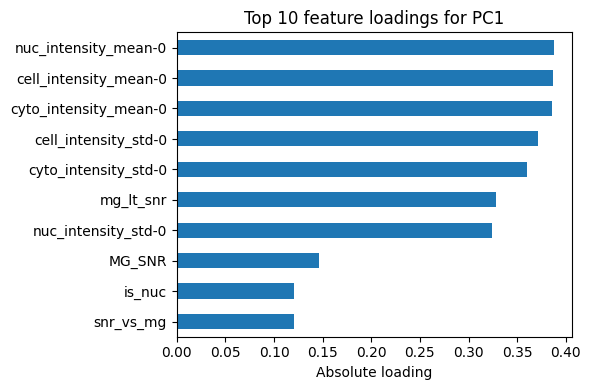

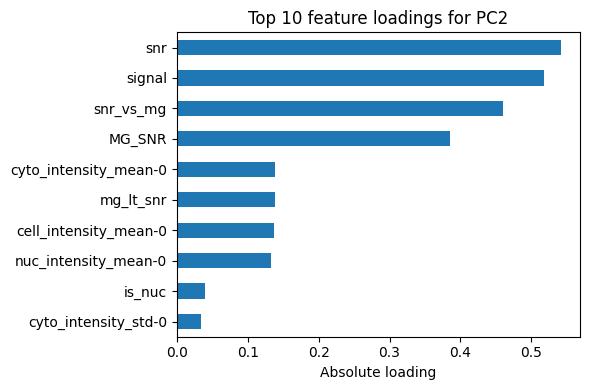

/Users/ericron/Desktop/AngelFISH/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


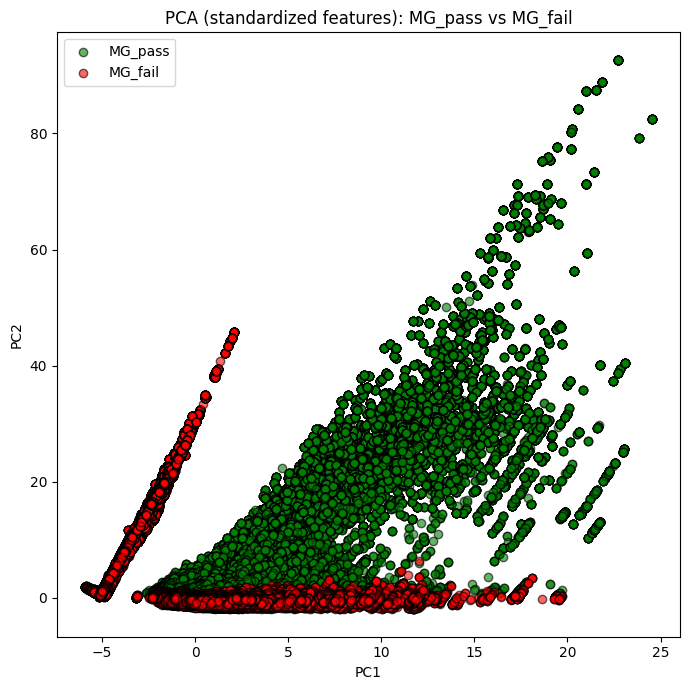

In [5]:
merged_spots_df = spots_total

# # 1) Point this at your merged spots CSV
# spots_path = '/Users/ericron/Desktop/AngelFISH/Publications/Ron_2024/Classification/DUSP1_D_Final_merged_spots_df_MG3_Abs4_Apr29.csv'  
# merged_spots_df = pd.read_csv(spots_path)

# 2) select numeric cols and drop coords/IDs
numeric_cols = merged_spots_df.select_dtypes(include=[np.number]).columns
drop = ['x_px','y_px','z_px','cell_label','nuc_label','h5_idx','unique_spot_id','unique_cell_id']
X = merged_spots_df[numeric_cols.drop(drop)].fillna(0)

# 3) standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4) PCA
pca = PCA(n_components=2)
coords = pca.fit_transform(X_scaled)
merged_spots_df['PC1'], merged_spots_df['PC2'] = coords[:,0], coords[:,1]

# 5) variance explained
print("Explained variance ratio:", pca.explained_variance_ratio_)

# 5a) get loadings and print top features
loadings = pd.DataFrame(pca.components_.T,
                        index=X.columns,
                        columns=['PC1','PC2'])

print("\nTop 10 contributors to PC1:")
print(loadings['PC1'].abs().sort_values(ascending=False).head(10))
print("\nTop 10 contributors to PC2:")
print(loadings['PC2'].abs().sort_values(ascending=False).head(10))

# 5b) bar-plots of top loadings
for comp in ['PC1','PC2']:
    top = loadings[comp].abs().nlargest(10).sort_values()
    plt.figure(figsize=(6,4))
    top.plot(kind='barh')
    plt.title(f"Top 10 feature loadings for {comp}")
    plt.xlabel("Absolute loading")
    plt.tight_layout()

# 6) original scatter
plt.figure(figsize=(7,7))
mask = merged_spots_df['MG_pass']
plt.scatter(merged_spots_df.loc[mask,  'PC1'],
            merged_spots_df.loc[mask,  'PC2'],
            c='green', label='MG_pass', alpha=0.6, edgecolors='k')
plt.scatter(merged_spots_df.loc[~mask, 'PC1'],
            merged_spots_df.loc[~mask, 'PC2'],
            c='red',   label='MG_fail', alpha=0.6, edgecolors='k')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('PCA (standardized features): MG_pass vs MG_fail')
plt.legend(); plt.tight_layout(); plt.show()

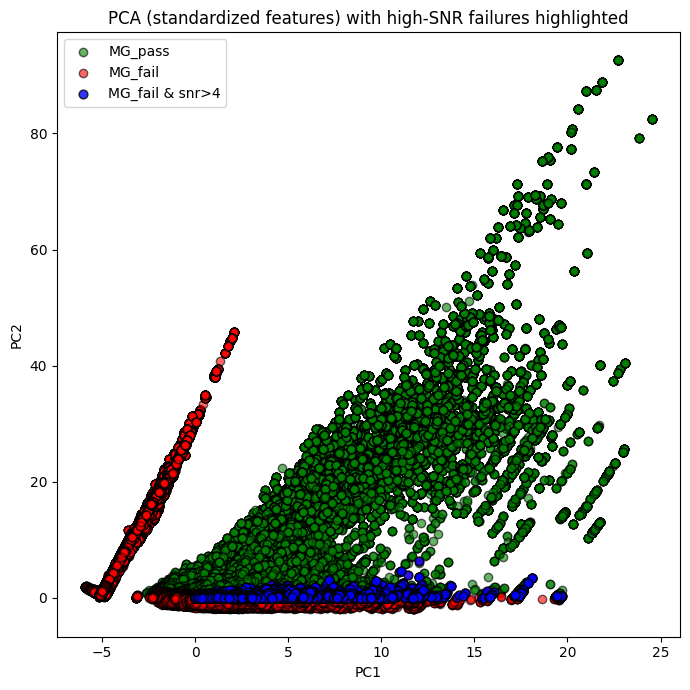

Found 60023 spots in that cloud
      unique_spot_id  h5_idx  fov       PC1       PC2  signal       snr  \
1513     15625001513       0    0  1.865349  0.150525  2170.0  8.756891   
1519     15625001519       0    0  1.865773  0.147264  2194.0  8.637422   
3585     15625003585       0    0  1.837872  0.012876  2200.0  7.208390   
3962     15625003962       0    1  2.878000  0.239561  2617.0  8.960423   
3984     15625003984       0    1  2.875515  0.205833  2783.0  8.110092   

        MG_SNR  snr_vs_mg  
1513  2.881704   5.875187  
1519  2.960696   5.676726  
3585  2.980444   4.227946  
3962  2.596179   6.364244  
3984  2.908419   5.201673  


In [6]:
# 1) define your “region of interest”
mask_cluster = (
    (~merged_spots_df['MG_pass'])           # only MG_fail
    & merged_spots_df['PC1'].between(0, 20)  # PC1 in [0,5]
    & merged_spots_df['PC2'].between(0, 20) # PC2 in [1,15]
    & (merged_spots_df['snr'] > 4)           # snr > 4
)

# 2) pull out those rows
cluster_spots = merged_spots_df[mask_cluster]

plt.figure(figsize=(7,7))

# original MG_pass vs MG_fail
mask = merged_spots_df['MG_pass']
plt.scatter(merged_spots_df.loc[mask,  'PC1'],
            merged_spots_df.loc[mask,  'PC2'],
            c='green', label='MG_pass', alpha=0.6, edgecolors='k')
plt.scatter(merged_spots_df.loc[~mask, 'PC1'],
            merged_spots_df.loc[~mask, 'PC2'],
            c='red',   label='MG_fail', alpha=0.6, edgecolors='k')

# overlay your high-SNR fails in blue
plt.scatter(cluster_spots['PC1'],
            cluster_spots['PC2'],
            c='blue',
            label='MG_fail & snr>4',
            alpha=0.8,
            s=40,
            edgecolors='k')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA (standardized features) with high-SNR failures highlighted')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# 3) inspect or save
print(f"Found {len(cluster_spots)} spots in that cloud")
print(cluster_spots[['unique_spot_id','h5_idx','fov','PC1','PC2','signal','snr', 'MG_SNR', 'snr_vs_mg']].head())
cluster_spots.to_csv('discarded_spot_cluster_abs4.csv', index=False)

In [ ]:
cluster_spots['MG_SNR'].hist(bins=50)
plt.xlabel('MG_SNR')
plt.ylabel('Count')
plt.title('MG_SNR distribution of spots in cluster')
plt.show()
cluster_spots['snr_vs_mg'].hist(bins=50)
plt.xlabel('snr_vs_mg')
plt.ylabel('Count')
plt.title('snr_vs_mg distribution of spots in cluster')
plt.show()
cluster_spots['snr'].hist(bins=50)
plt.xlabel('snr')
plt.ylabel('Count')
plt.title('snr distribution of spots in cluster')
plt.show()
cluster_spots['signal'].hist(bins=50)
plt.xlabel('signal')
plt.ylabel('Count')
plt.title('signal distribution of spots in cluster')
plt.show()

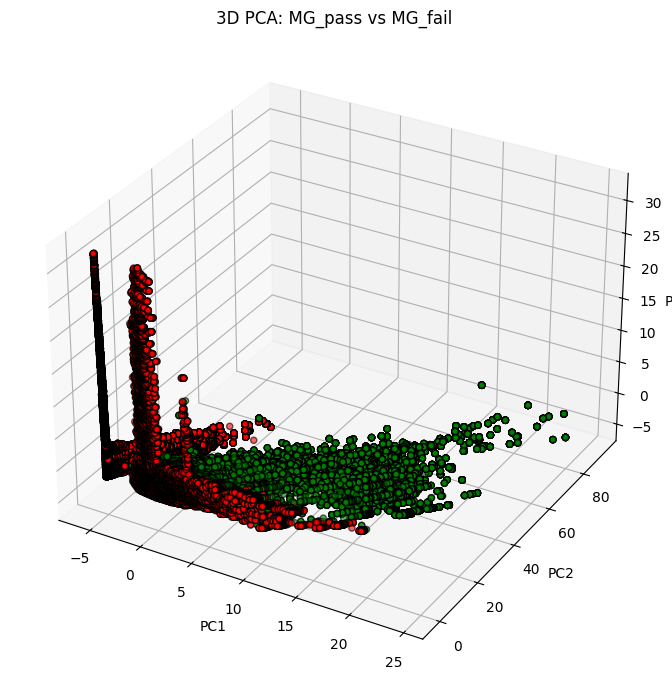

In [7]:
from mpl_toolkits.mplot3d import Axes3D

# 1) redo PCA
pca3 = PCA(n_components=3)
coords3 = pca3.fit_transform(X_scaled)
merged_spots_df[['PC1','PC2','PC3']] = coords3

# 2) quick 3D scatter
fig = plt.figure(figsize=(7,7))
ax  = fig.add_subplot(111, projection='3d')
cmap = merged_spots_df['MG_pass'].map({True:'green', False:'red'})

ax.scatter(merged_spots_df.PC1,
           merged_spots_df.PC2,
           merged_spots_df.PC3,
           c=cmap, alpha=0.6, edgecolors='k')
ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')
ax.set_title('3D PCA: MG_pass vs MG_fail')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# X_scaled from before…

pca3 = PCA(n_components=3)
coords3 = pca3.fit_transform(X_scaled)
merged_spots_df[['PC1','PC2','PC3']] = coords3

In [ ]:
from sklearn.cluster import DBSCAN

# stack your 3-PC coords
pts = merged_spots_df[['PC1','PC2','PC3']].values

# tweak eps/min_samples until that blob comes out as one label
db = DBSCAN(eps=1.2, min_samples=20).fit(pts)
merged_spots_df['db_label'] = db.labels_   # –1 means “noise”

# see which label lives in your [0–5],[1–15] slice
roi = (
    (~merged_spots_df['MG_pass']) &
    merged_spots_df['PC1'].between(0,5) &
    merged_spots_df['PC2'].between(1,15)
)
print("Labels in ROI:", merged_spots_df.loc[roi,'db_label'].value_counts())

In [ ]:
cluster_spots = merged_spots_df[merged_spots_df['db_label']==L]
print(f"Found {len(cluster_spots)} spots in cluster {L}")
cluster_spots.to_csv("MG_fail_blob.csv", index=False)